# **Introduction to Image Processing**

** Dear students this is your first assignment in Image processing course, in the context of this assignment you have to:**
* **complete `2-enhancement.ipynb` up to section 2.7**
* **complete this notebook `2-enhancement-supplementary.ipynb`**
* **add your changes, commit and push your completed assignment to your github repo**

`2-enhancement-supplememtary.ipynb` provides more information on section 2.7

## 2.7 Your own implementation 

### Q.1 Import the required libraries and functions

In [1]:
% matplotlib inline
% pprint off
# Matplotlib library
import matplotlib.pyplot as plt
from matplotlib import cm

# Numpy library
import numpy as np
from skimage import io

image_path = './images/'
### import the libraries you think its necessary for your task 

Pretty printing has been turned OFF


### Q.2 Contrast streching 

** Define your function which stretch the image contrast, `cont_str`, using minimum and maximum values from the image **

**This function should accept the input image, calculates the minimum and maximum and rescales the intensities.**

** Return the image as uint8 **

In [2]:
def StretchContrast (image):
    """
    This function uses the technique of contrast streaching using
    histogram modification ,it essentially implements the formula
    
    g = 255(f-min)/(max-min)
    
    """
    
    MIN = image.min();
    MAX = image.max();
    
    modified =  255. * (image - MIN) / (MAX - MIN)
    
    
    return modified.astype("ubyte")

**Use your function to transform the  gray version of `satellite.jpg` image (ubyte format), show the original image and the transformed image and their histogram**

/home/masters/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


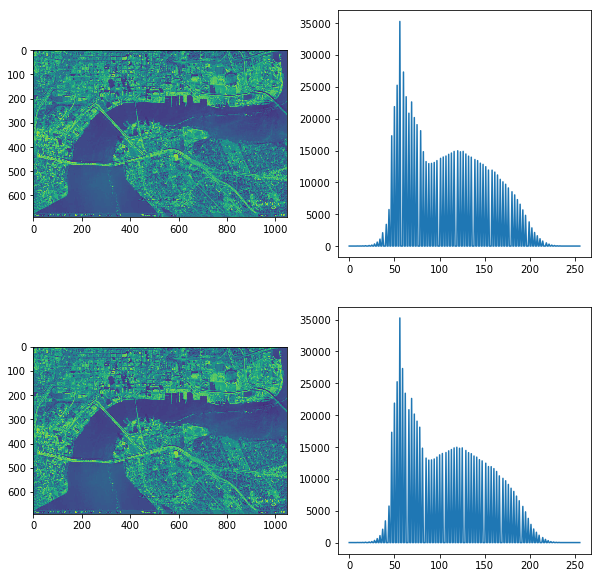

In [4]:
import skimage
image_name='satellite.jpg'     #import the image
sat = io.imread(image_path.__add__(image_name), as_grey=True)      # read as a gray value
sat_im = skimage.img_as_ubyte (sat)    # convert img as a ubyte

modified = StretchContrast(sat_im)     # apply contrast streaching
#io.imshow(modified)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))   
ax0, ax1, ax2, ax3 = axes.ravel()

ax0.imshow(sat_im) 


bins, bins_c = np.histogram(sat_im, 256)
ax1.plot(bins)


ax2.imshow(modified)


bins1, bins_c = np.histogram(modified, 256)
ax3.plot(bins1)





### Q.3 Histogram equalization
Histogram equalization can be used to enhance the contrast in images.

The idea behind the histogram equalization process is that each gray level should have an equal contribution in the image. The function allowing such transformation is in fact the cumulative density function.

**Define your own histgram equalization function, `hist_eq`**

**This function should accpet the image, max_int and min_int and return the transformed image and its cdf**

In [5]:
def hist_eq (image , min_int , max_int):
    """
    Histogram equalization function takes in the image ,and the range of intensity to equalize
    the image and returns the transformed image and its cdf.
    
    It implemets this by first normalizing the histogram ,then calculate the cumulative sum of the historgam 
    and multiply the modified image values with the range of given parameters.
    """
    hist, bin_edges = np.histogram(image.flatten(), 256, [min_int, max_int])
    
    Normalized = hist /  np.sum(hist)
    cdf = np.cumsum (Normalized)
    cdf = cdf * (max_int - min_int)
    
    modified = np.zeros_like(image)
    s1, s2 = image.shape
    
    
    # transfer function implementation
    
    for i in range(0, s1):
        for j in range(0, s2):
            modified[i, j] = cdf[image[i, j]] 
    
            
    hist_new, bin_edges_new = np.histogram(modified.flatten(), 256, [min_int, max_int])
    Normalized_new = hist_new / np.sum(hist)
    cdf_new = np.cumsum (Normalized_new)*(max_int - min_int)
    
    
    return modified , cdf_new

** Use your function to transform the gray version of `satellite.jpg` image again in ubyte format**

** max_int = 255, min_int = 0 **

In [6]:
modified2 , cdf = hist_eq ( sat_im , 0 , 255)

**Show the transformed image and its histogram**

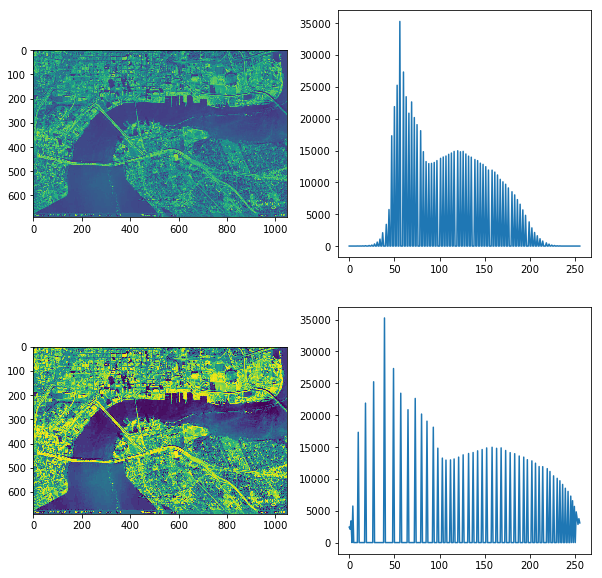

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))   
ax0, ax1, ax2, ax3 = axes.ravel()

ax0.imshow(sat_im) 


bins, bins_c = np.histogram(sat_im, 256)
ax1.plot(bins)


ax2.imshow(modified2)


bins1, bins_c = np.histogram(modified2, 256)
ax3.plot(bins1)


### Q.4 Histogram matching

** In this section we will perform histogram matching, the `hist_match` function is mostly defined here**
** `hist_match` uses the function that should define the Q.3 `hist_eq`, check the comments in the code as well **
 
** Explain the process of histogram matching in your own words**

In [15]:
def find_inverse_mapping(mapping):
    # Initialise the inverse
    inv_mapping = np.zeros(mapping.shape)
    # Find the index that we can affect for sure
    idx_inv_map = np.unique(mapping)
    
    # For each index
    for idx in idx_inv_map:
        # Find the corresponding index value
        int_val = np.where(mapping == idx)[0][0]
        # Affect this value for the inverse mapping
        inv_mapping[idx] = int_val
        
    # Find the first index which is not zero
    first_elt_idx = np.nonzero(inv_mapping)[0][0]
    for i, elt in enumerate(inv_mapping[first_elt_idx:-1]):
        if (elt == 0):
            inv_mapping[i + first_elt_idx] = inv_mapping[i + first_elt_idx - 1]
        
    return inv_mapping.astype('uint8')



In [16]:
def hist_match(img, pdf_to_fit, min_int, max_int):
    # Equalize img
    
    ## hist_eq is actually the function that you should implement in the previous Question 
    img_eq, cdf_eq = hist_eq(img, min_int, max_int)
   
    
    # We need to make the matching now
    ## Compute the transform G
    
    ### Compute the cdf
    cdf = np.cumsum(pdf_to_fit)
    
    ### Multiply the cdf by the number of gray values
    cdf_real = cdf * float(max_int)
    ### Round the cdf
    G = np.floor(cdf_real).astype('int')
    
    ## But we need the inverse
    G_1 = find_inverse_mapping(G)
    
    img_match = np.zeros((img_eq.shape[0], img_eq.shape[1]))
    for i in range (np.shape(img_eq)[0]):
        for j in range (np.shape(img_eq)[1]):
            img_match[i][j] = G_1[int(img_eq[i][j])]
    
    return img_match  

Histogram matching finds the image match to a modified image. Given a function to fit to, the match image is found by transforming the modified image using the inverse mapping of the Cumulative density function of the given function to fit to. The algorithm typically performs the following tasks sequentially,

1- Takes an image and finds a modified image by Histogram equalization
2- computed the Cumulative Distribuion function of the pdf-to-fit (the probability distribution function we want the output to fit to)
3- computes the inverse mapping of the cdf to ensure mapping of every point into an input point without the need to interpolate.(each coordiante has a different value now)
4- Transforms the modified image with the new mapping cdf (inverse mapping) to find the match image
5- Returns the match


Since the pdf to fit is given , the modified image is expected to have a histogram similar to a gaussian distribition.This is so because the modified image is mapped to fit into the gaussian probabilistic distribution.

**Creating a manual pdf following a gaussian distribution**

In [21]:
from scipy.stats import norm
max_img = 255.;
x = np.arange(max_img+1)
pdf_to_fit = norm.pdf(x, 150, 30)


**Use the defined function to match the histogram of gray version of satellite image to `pdf_to_fit`**

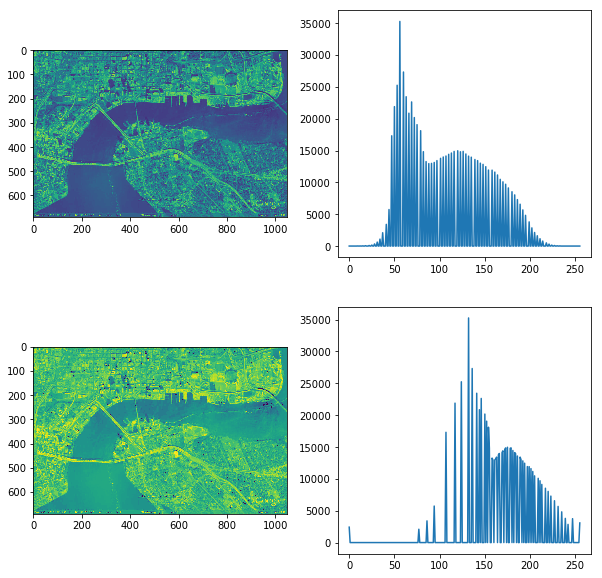

In [22]:
sat_match = hist_match(sat_im , pdf_to_fit, 0 , 255)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))   
ax0, ax1, ax2, ax3 = axes.ravel()

ax0.imshow(sat_im) 


bins, bins_c = np.histogram(sat_im, 256)
ax1.plot(bins)


ax2.imshow(sat_match)


bins1, bins_c = np.histogram(sat_match, 256)
ax3.plot(bins1)


### Q.5 

** Explain the difference between log transform enhancement and gamma transform **


During log transformation, the dark pixels in an image are expanded as compare to the higher pixel values. The higher pixel values are kind of compressed in log transformation.
It uses the formula $$ s = clog(r+1)$$ where s and r are the pixel values of the output and the input image and c is a constant. The value 1 is added to each of the pixel value of the input image because if there is a pixel intensity of 0 in the image, then log (0) is equal to infinity. So 1 is added, to make the minimum value at least 1.
Log transformation does not change the slope of the histogram of the image that much.It only expands the intensity of dark pixles.

But gamma transsformation is a power transformation so it achieves different results for different values of \gamma.
During gamma transformation, we use the formula  $s = cr^{\gamma}$.for different values of gamma, different slopes are obtained for the histogram so the magnitude of the image changes well.lower \gamma values (less than 1) stretch lower intensity levels while higher \gamma values stretch higher intensity values.The choise of \gamma depends on the result proposed to be achieved.


** Explain how sigmoid function enhances the image **

Sigmoid function is another non-linear transformation of image used for enhancement of the images.

The transformation function of sigmoid is formulated as $s = \frac{1}{1 + \exp{\left(c(t - r)\right)}}$.amd fpr different values of $c$ , the image is transformed a bit differently.